In [1]:
import numpy as np
import mne
import matplotlib.pyplot as plt
import math
%matplotlib qt

In [2]:
def show_data_informations(signal, signal_type):
    print(f"Tipo de datos {signal_type}:", type(signal))
    print(f"Forma de los datos {signal_type}:", signal.shape)

In [3]:
EOG_all_epochs = 'EOG_all_epochs.npy'
EMG_all_epochs = 'EMG_all_epochs.npy'
EEG_all_epochs = 'EEG_all_epochs.npy'

eog_data = np.load(EOG_all_epochs)
emg_data = np.load(EMG_all_epochs)
eeg_data = np.load(EEG_all_epochs)

show_data_informations(eog_data, 'EOG')
show_data_informations(emg_data, 'EMG')
show_data_informations(eeg_data, 'EEG')

Tipo de datos EOG: <class 'numpy.ndarray'>
Forma de los datos EOG: (3400, 512)
Tipo de datos EMG: <class 'numpy.ndarray'>
Forma de los datos EMG: (5598, 512)
Tipo de datos EEG: <class 'numpy.ndarray'>
Forma de los datos EEG: (4514, 512)


In [4]:
def generate_data(data, sfreq, ch_names, ch_types, dictionary):
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
    raw_eog = mne.io.RawArray(data.reshape(1, -1), info)
    raw_eog.plot(scalings=dictionary, title='Señal', show=True, block=True)

In [5]:
generate_data(eog_data, 512, ['EOG'], ['eog'], dict(eog=1000))

Creating RawArray with float64 data, n_channels=1, n_times=1740800
    Range : 0 ... 1740799 =      0.000 ...  3399.998 secs
Ready.
Using matplotlib as 2D backend.
Channels marked as bad:
none


In [6]:
generate_data(emg_data, 512, ['EMG'], ['emg'], dict(emg=100000))

Creating RawArray with float64 data, n_channels=1, n_times=2866176
    Range : 0 ... 2866175 =      0.000 ...  5597.998 secs
Ready.
Channels marked as bad:
none


In [7]:
generate_data(eeg_data, 512, ['EEG'], ['eeg'], dict(eeg=10000))

Creating RawArray with float64 data, n_channels=1, n_times=2311168
    Range : 0 ... 2311167 =      0.000 ...  4513.998 secs
Ready.
Channels marked as bad:
none


In [8]:
def get_rms(records):
    return math.sqrt(sum([x ** 2 for x in records]) / len(records))

def random_signal(signal, combine_num):
    random_result=[]

    for i in range(combine_num):
        random_num = np.random.permutation(signal.shape[0])
        shuffled_dataset = signal[random_num, :]
        shuffled_dataset = shuffled_dataset.reshape(signal.shape[0],signal.shape[1])
        random_result.append(shuffled_dataset)
    random_result  = np.array(random_result)
    return  random_result

In [9]:
EEG_all_random = np.squeeze(random_signal(signal=eeg_data, combine_num=1))
NOISE_all_random = np.squeeze(random_signal(signal=eog_data, combine_num=1))

In [10]:
SNR_dB = np.random.uniform(-7, 2, (eeg_data.shape[0]))
print("Forma de SNR_dB:", SNR_dB.shape)
SNR = 10 ** (0.1 * SNR_dB)

Forma de SNR_dB: (4514,)


In [11]:
num_eeg_samples = EEG_all_random.shape[0]
num_eog_samples = eog_data.shape[0]

print("Número de muestras de EEG:", num_eeg_samples)
print("Número de muestras de EOG:", num_eog_samples)

Número de muestras de EEG: 4514
Número de muestras de EOG: 3400


In [12]:
needed_repetitions = int(np.ceil(num_eeg_samples / num_eog_samples))  # Calcula cuántas veces repetir
print("Repeticiones necesarias:", needed_repetitions)

NOISE_all_random = random_signal(signal=eog_data, combine_num=needed_repetitions)
NOISE_all_random = NOISE_all_random.reshape(-1, eog_data.shape[1])  # Aplanar a 2D

print("Número total de muestras de ruido después de aplanar:", NOISE_all_random.shape[0])

if NOISE_all_random.shape[0] < num_eeg_samples:
    extra_needed = num_eeg_samples - NOISE_all_random.shape[0]
    extra_noise = random_signal(signal=eog_data, combine_num=1)
    extra_noise = extra_noise.reshape(-1, eog_data.shape[1])
    NOISE_all_random = np.concatenate((NOISE_all_random, extra_noise), axis=0)

NOISE_all_random = NOISE_all_random[:num_eeg_samples]

print("Forma final de NOISE_all_random:", NOISE_all_random.shape)
print("Forma de EEG_all_random:", EEG_all_random.shape)

SNR_dB = np.random.uniform(-7, 2, num_eeg_samples)
SNR = 10 ** (0.1 * SNR_dB)
print("Forma de SNR:", SNR.shape)

noiseEEG = []
NOISE_adjust = []
for i in range(num_eeg_samples):
    eeg = EEG_all_random[i]
    noise = NOISE_all_random[i]

    coe = get_rms(eeg) / (get_rms(noise) * SNR[i])
    noise = noise * coe
    noise_eeg = eeg + noise

    NOISE_adjust.append(noise)
    noiseEEG.append(noise_eeg)

noiseEEG = np.array(noiseEEG)
NOISE_adjust = np.array(NOISE_adjust)

EEG_end_standard = []
noiseEEG_end_standard = []
for i in range(num_eeg_samples):
    eeg_std = EEG_all_random[i] / np.std(noiseEEG[i])
    EEG_end_standard.append(eeg_std)
    noiseeeg_std = noiseEEG[i] / np.std(noiseEEG[i])
    noiseEEG_end_standard.append(noiseeeg_std)

EEG_end_standard = np.array(EEG_end_standard)
noiseEEG_end_standard = np.array(noiseEEG_end_standard)

print("Forma final de EEG_end_standard:", EEG_end_standard.shape)
print("Forma final de noiseEEG_end_standard:", noiseEEG_end_standard.shape)

Repeticiones necesarias: 2
Número total de muestras de ruido después de aplanar: 6800
Forma final de NOISE_all_random: (4514, 512)
Forma de EEG_all_random: (4514, 512)
Forma de SNR: (4514,)
Forma final de EEG_end_standard: (4514, 512)
Forma final de noiseEEG_end_standard: (4514, 512)


In [13]:
generate_data(EEG_end_standard, 512, ['EEG'], ['eeg'], dict(eeg=10))

Creating RawArray with float64 data, n_channels=1, n_times=2311168
    Range : 0 ... 2311167 =      0.000 ...  4513.998 secs
Ready.
Channels marked as bad:
none


In [14]:
generate_data(noiseEEG_end_standard, 512, ['EEG'], ['eeg'], dict(eeg=10))

Creating RawArray with float64 data, n_channels=1, n_times=2311168
    Range : 0 ... 2311167 =      0.000 ...  4513.998 secs
Ready.
Channels marked as bad:
none


Creating RawArray with float64 data, n_channels=2, n_times=2311168
    Range : 0 ... 2311167 =      0.000 ...  4513.998 secs
Ready.


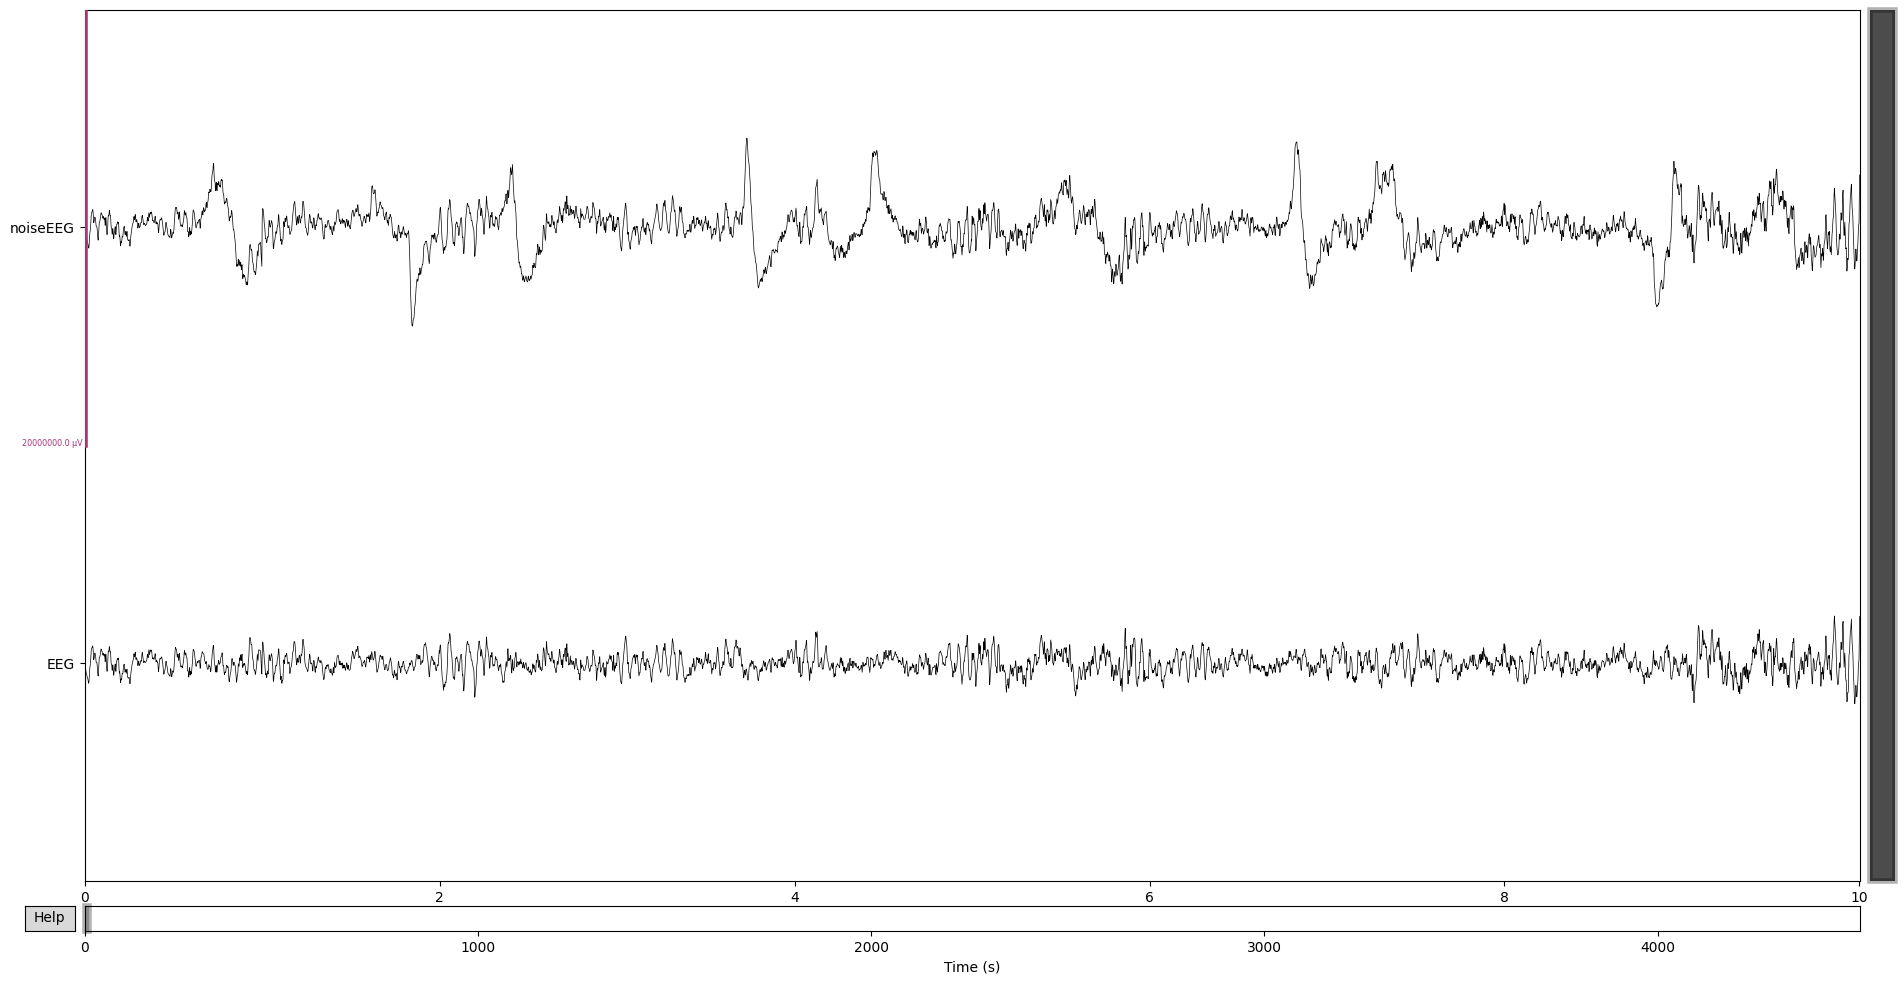

In [16]:
noiseEEG_flat = noiseEEG_end_standard.flatten()
EEG_flat = EEG_end_standard.flatten()
data = np.vstack((noiseEEG_flat, EEG_flat))
sfreq = 512
info = mne.create_info(ch_names=['noiseEEG', 'EEG'], sfreq=sfreq, ch_types=['eeg', 'eeg'])
raw = mne.io.RawArray(data, info)
raw.plot(scalings=dict(eeg=10))